In [1]:
import torch
import torch.nn.functional as F
from models import Create_nets
from datasets import get_dataloader
#from options import TrainOptions
from torchvision import models
import os
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import cv2
from utils.results import *
from matplotlib.cm import viridis
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from utils.dataloader import get_paths_mvtec
from datasets import ImageDataset_mvtec
from torch.utils.data import DataLoader
import copy

In [2]:
import os
import json

class TrainOptions:
    def __init__(self):
        self.exp_name = "DEV_USDR"
        self.epoch_start = 0
        self.epoch_num = 1
        self.factor = 1
        self.seed = 233
        self.fixed_seed_bool = True
        self.test_seed = 400
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.data_category = "screw"
        self.data_set = "mvtec"
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.results_dir = 'results'
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'
        self.contamination_rate = 0.1
        self.assumed_contamination_rate = 0.1
        self.mode = 'mvtec'
        self.development = False
        self.parser = None
        self.initialized = False


In [37]:
args = TrainOptions()
# os.makedirs(args.results_dir, exist_ok=True)
# os.makedirs(os.path.join(args.results_dir, args.data_set, f'contamination_{int(args.contamination_rate*100)}', f'{args.exp_name}-{args.data_category}', args.image_result_dir), exist_ok=True)
EXPERIMENT_PATH = os.path.join(args.results_dir,args.data_set ,f'contamination_{int(args.contamination_rate*100)}',f'{args.exp_name}-{args.data_category}')

try:
    with open(os.path.join('configurations', f'{args.data_set}.json'), 'r') as file:
        dataset_parameters = json.load(file)
    setattr(args, 'dataset_parameters', dataset_parameters)
except FileNotFoundError:
    print(f"Configuration file for {args.data_set} not found. Proceeding with default parameters.")
    setattr(args, 'dataset_parameters', {})
    
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.cuda.manual_seed(args.seed)

In [4]:
anomaly_categories={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]
    }
category='screw'
anocat=anomaly_categories[category]

In [5]:
normal_images, validation_images, sampled_anomalies_for_train, sampled_anomalies_for_val, good_images_test, remaining_anomalies_test = get_paths_mvtec(args,verbose=True)
DATA_PATH=os.path.join(args.data_root,args.data_category)
# combine good and anomalies
train_data=normal_images+sampled_anomalies_for_train
labels_train=[0]*len(normal_images)+[1]*len(sampled_anomalies_for_train)

category: screw, normals train:  320, anomalies test: 119, normal test: 41
anomalies test total:     {'manipulated_front': 24, 'scratch_head': 24, 'scratch_neck': 25, 'thread_side': 23, 'thread_top': 23}
anomalies test sampled:   {'manipulated_front': 6, 'scratch_head': 6, 'scratch_neck': 6, 'thread_side': 6, 'thread_top': 6}
anomalies test remaining: {'manipulated_front': 18, 'scratch_head': 18, 'scratch_neck': 19, 'thread_side': 17, 'thread_top': 17}


In [20]:
import pickle
file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_24_05_24_8set-screw/allpaths.pkl"
with open(file_path, "rb") as file:
    data = pickle.load(file)
    
file_path = "/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_24_05_24_8set-screw/allscores.pkl"
with open(file_path, "rb") as file:
    scores = pickle.load(file)
    
file_path = '/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_24_05_24_8set-screw/experiment_paths.json'
with open(file_path, 'r') as file:
    experimentpaths = json.load(file)

df = pd.read_pickle('/home/bule/projects/UTRAD/results/mvtec/contamination_10/USDR_24_05_24_8set-screw/USDR_window:182_stride:42.pkl')

In [34]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.cuda.manual_seed(args.seed)


idx = np.arange(len(experimentpaths['train']))
np.random.shuffle(idx)
alldata_train = [experimentpaths['train'][i] for i in idx] 

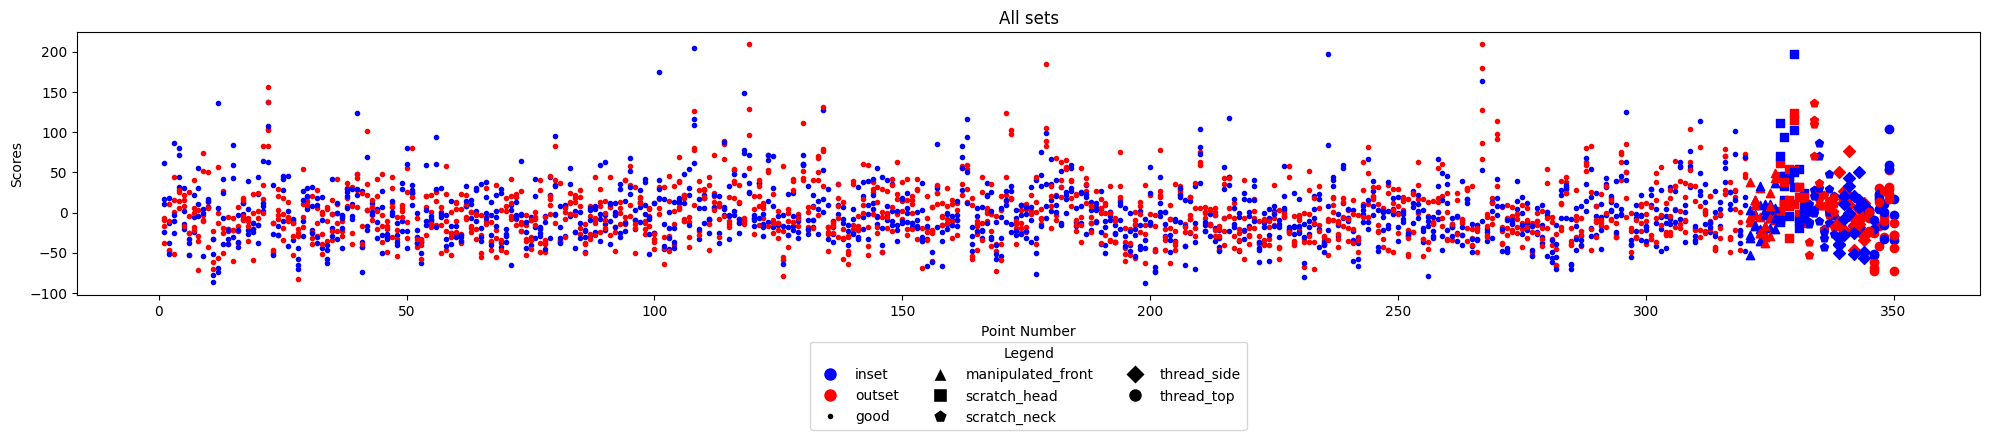

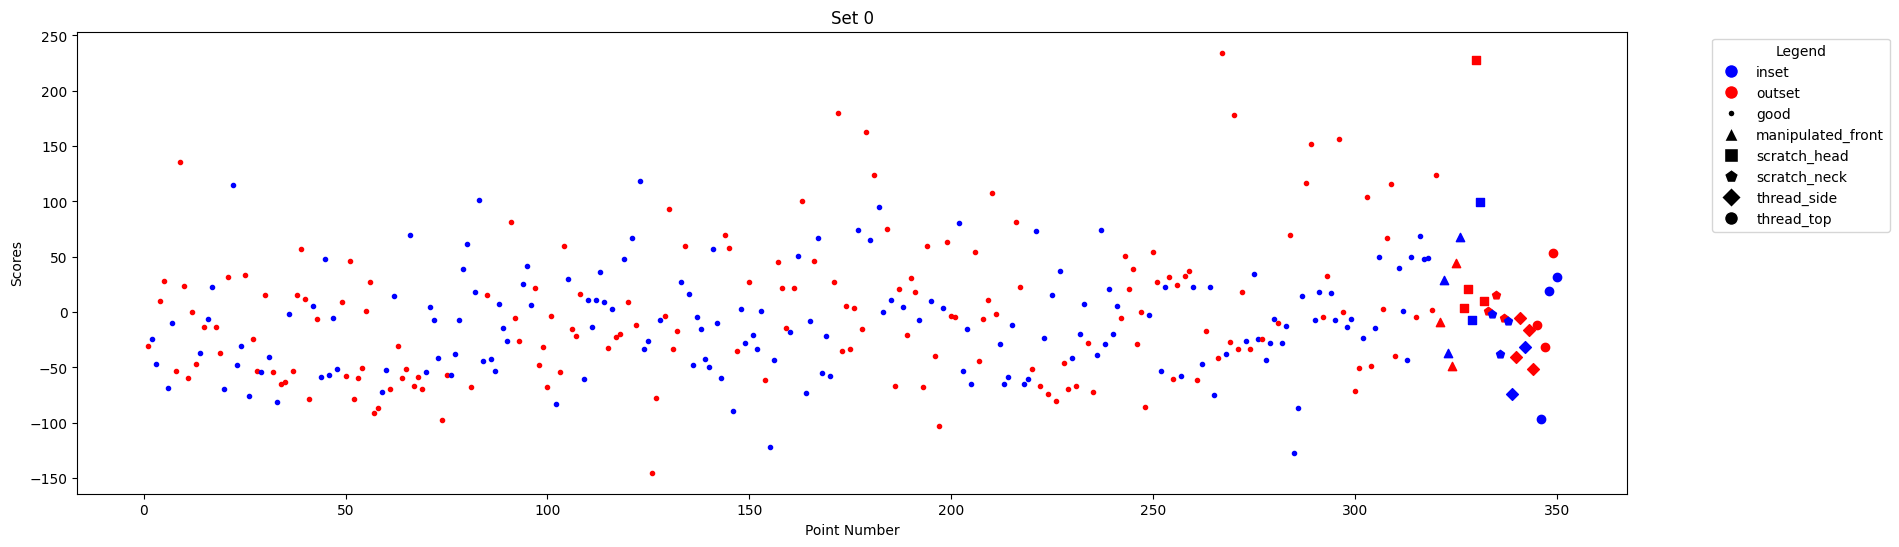

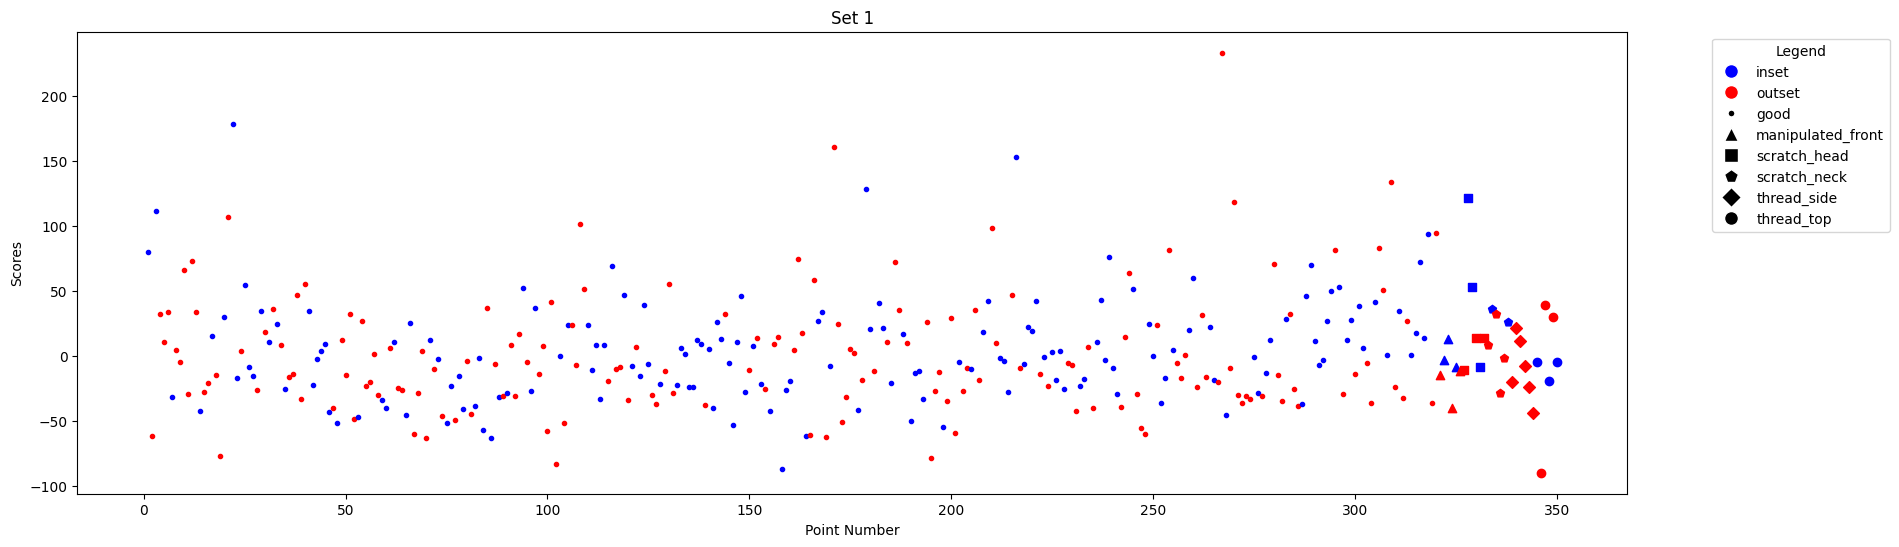

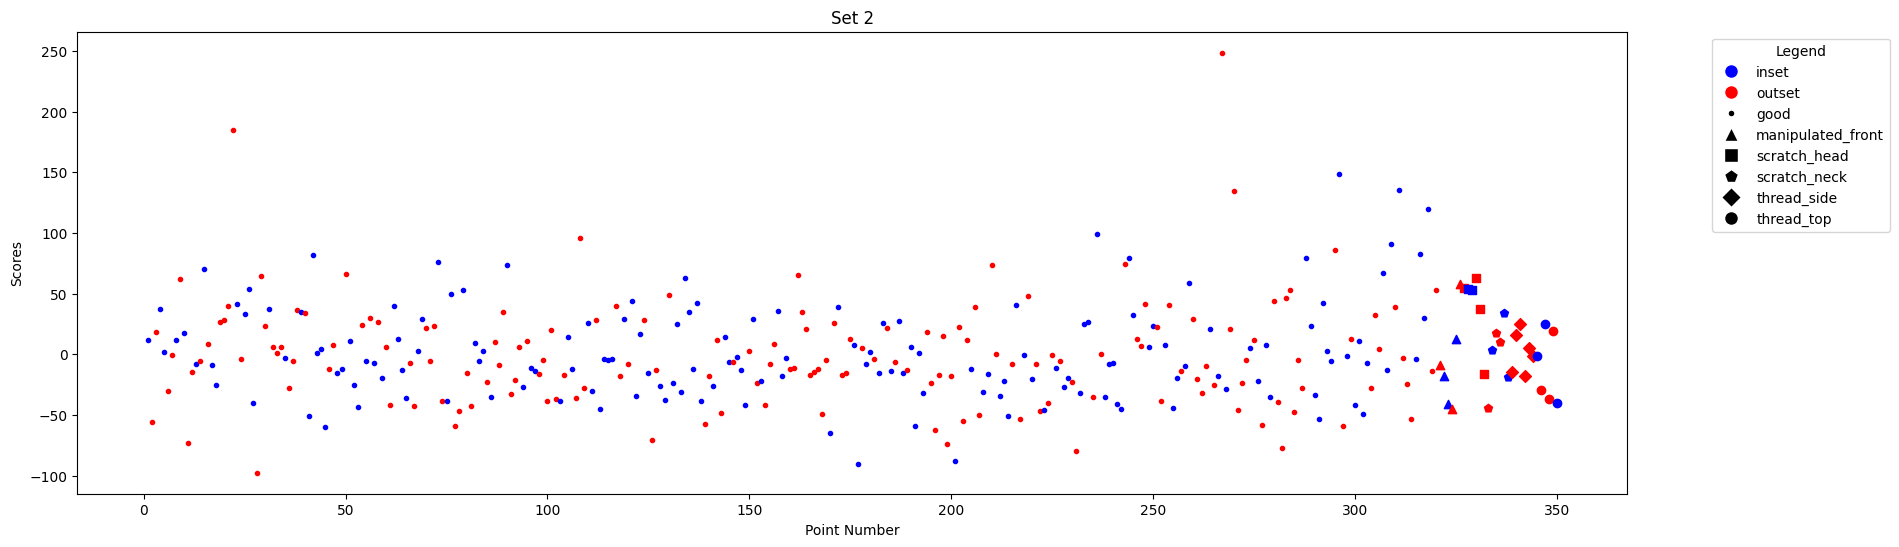

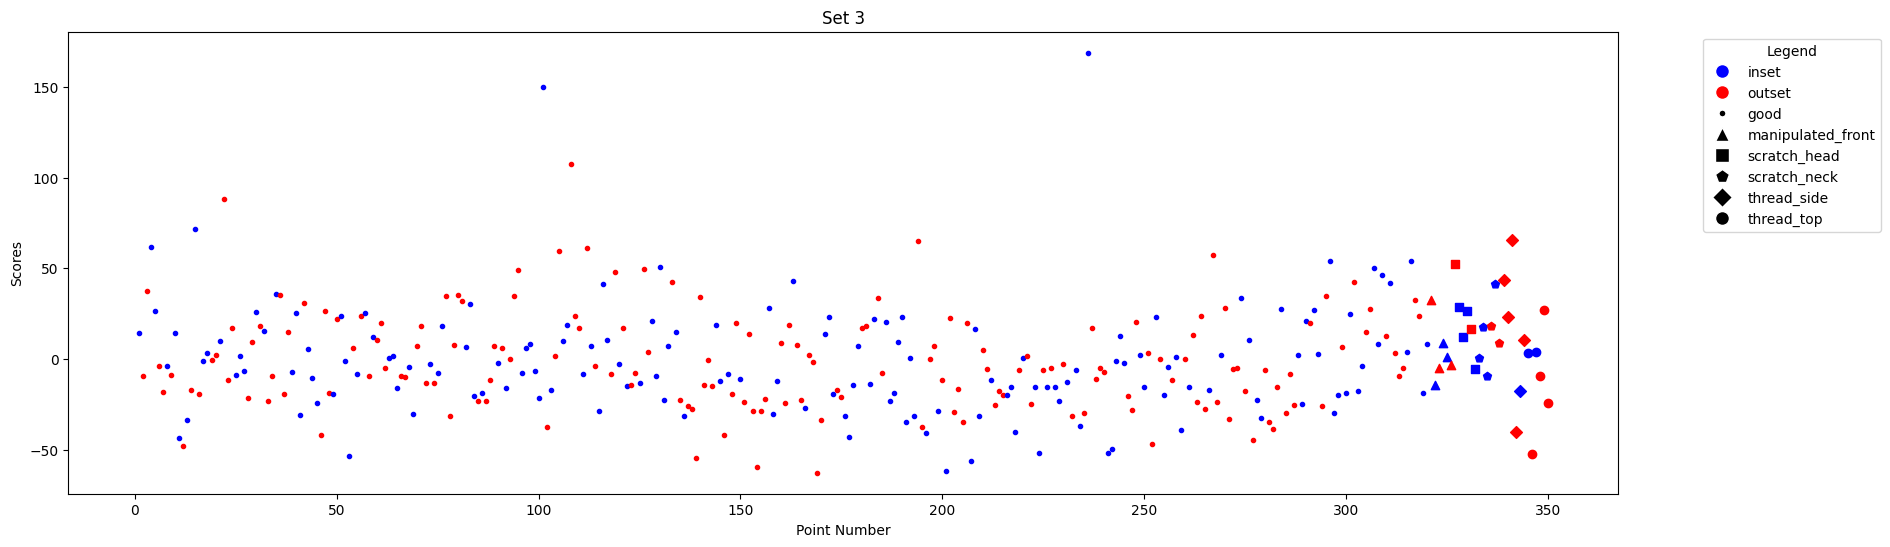

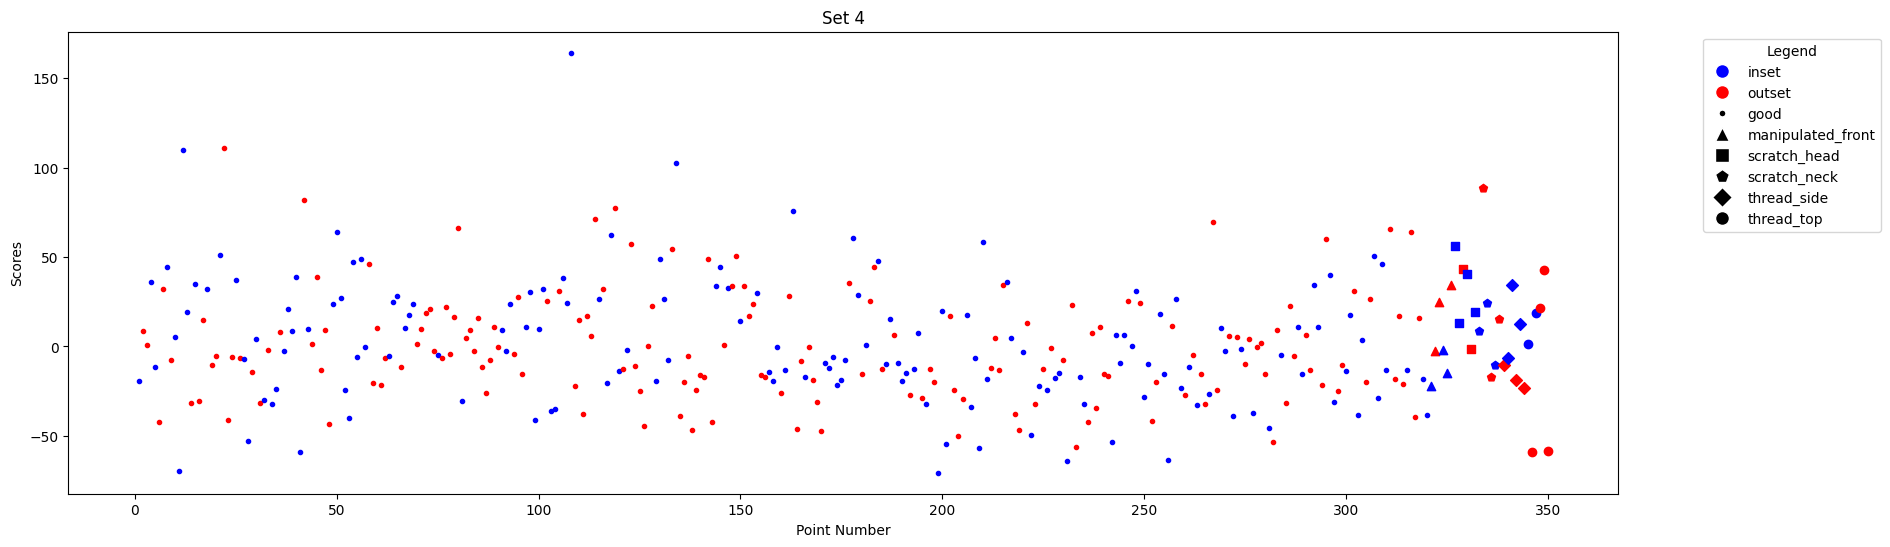

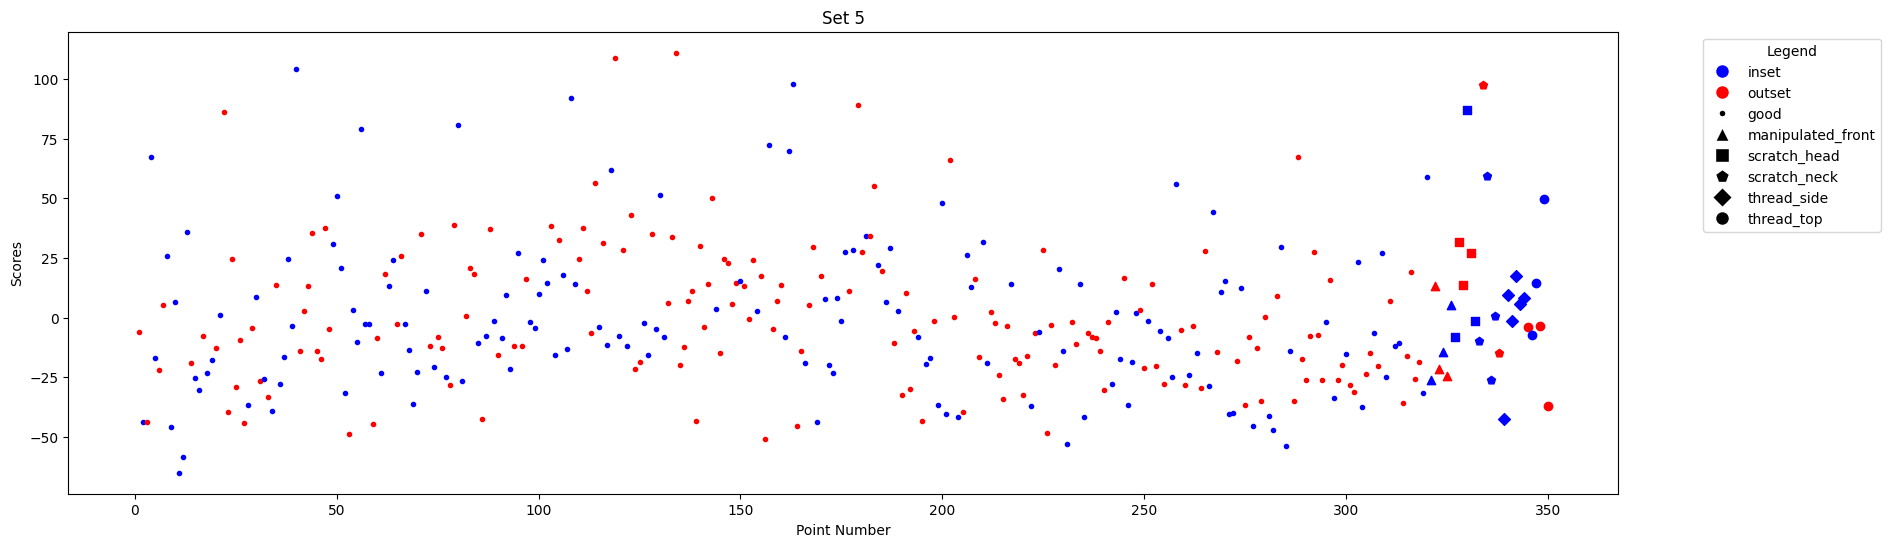

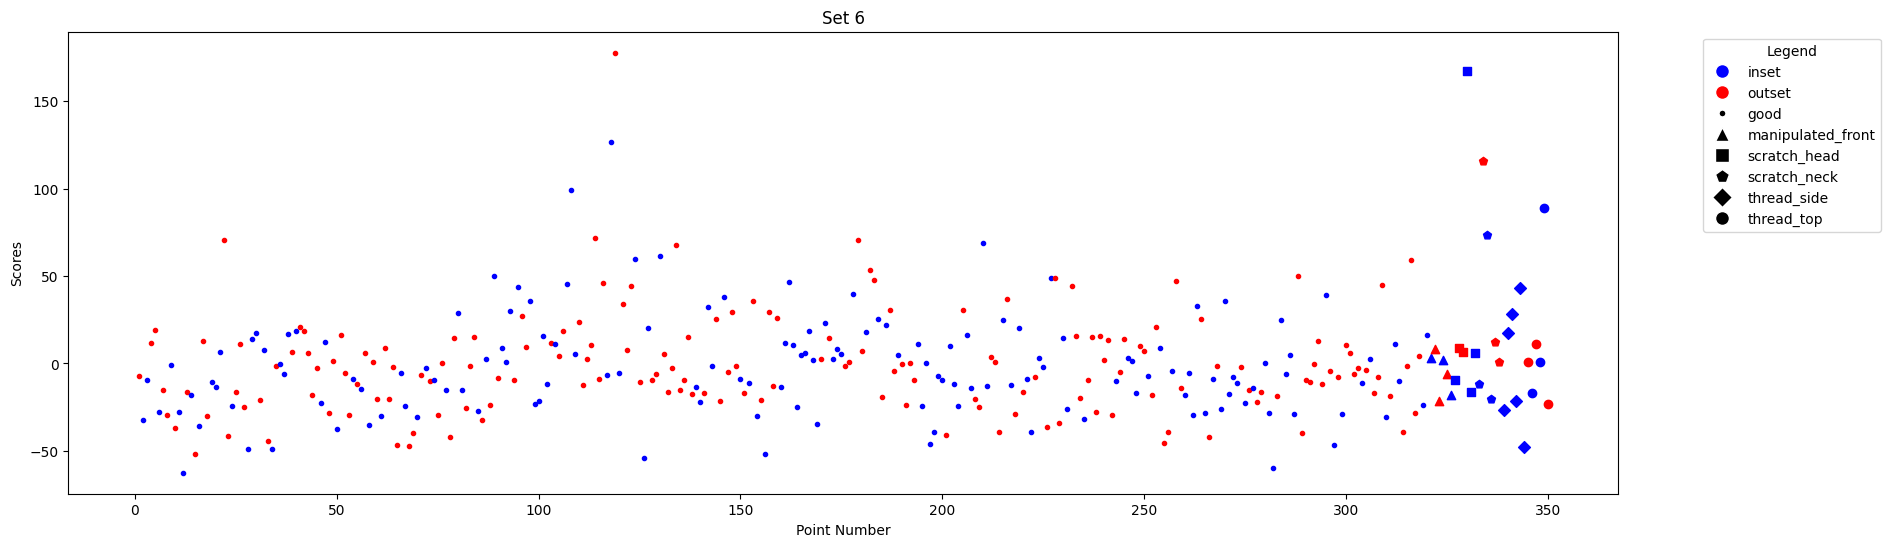

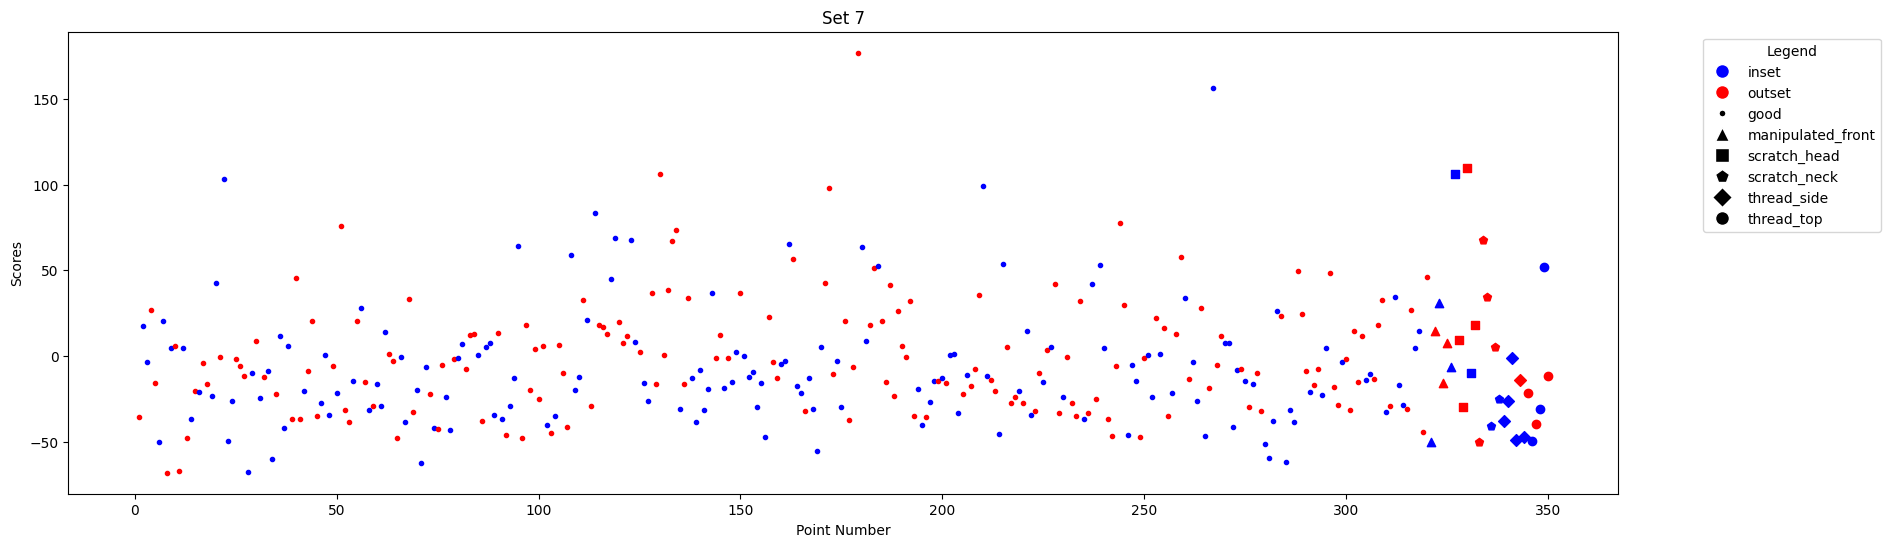

In [7]:
set_j=0
cats=['good']+anocat

orig_paths=experimentpaths['train']

idx = np.arange(len(orig_paths))
np.random.shuffle(idx)


orig_paths=[orig_paths[id]for id in idx]



# indicator for anomaly
ano_ind=[0]*len(orig_paths)
for n,cat in enumerate(cats):
    for i in range(len(ano_ind)):
        if cat in orig_paths[i]:
            ano_ind[i]=n


inset_tot={i:[] for i in np.arange(scores.shape[1])}
outset_tot={i:[] for i in np.arange(scores.shape[1])}

################################# ALLSETS togehter
plt.figure(figsize=(20, 6))
for set_j in range(scores.shape[0]):
    # indicator inset or not
    inset_ind=[1 if ptf in data[set_j] else 0 for ptf in orig_paths]
    scores_j=scores[set_j]
    
    combined = list(zip(scores_j, ano_ind, inset_ind))
    sorted_combined = sorted(combined, key=lambda x: x[1])
    sorted_scores_j, sorted_ano_ind, sorted_inset_ind = zip(*sorted_combined)
    sorted_scores_j=(np.array(sorted_scores_j)-np.mean([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==1]))/np.var([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==1])

    ## create difference dataset:
    
    for n,comm in enumerate(zip(scores_j,inset_ind)):
        if comm[1]==1:
            inset_tot[n].append(comm[0])
        else:
            outset_tot[n].append(comm[0])
    
    
    # Create a bar plot
    # plt.figure(figsize=(20, 6))
    colors = ['blue' if 0 == sorted_inset_ind[x] else 'red' for x in range(len(sorted_scores_j))] 
    markers_list = ['.', '^', 's', 'p', 'D','o'] 
    color_labels = {'blue': 'inset', 'red': 'outset'}

    markers=[markers_list[x] for x in sorted_ano_ind]
    x_values = list(range(1, len(sorted_scores_j) + 1))

    # Create a scatter plot
    for i in range(len(sorted_scores_j)):
        plt.scatter(x_values[i], sorted_scores_j[i], color=colors[i], marker=markers[i])

    # Add title and labels
    # Add legend for colors and markers
    legend_elements = []
    for color in color_labels:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=color_labels[color]))

    for i, marker in enumerate(markers_list):
        legend_elements.append(plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='k', markersize=10, label=cats[i]))

plt.title(f'All sets')
plt.xlabel('Point Number')
plt.ylabel('Scores')
# Add legend below the plot
plt.legend(handles=legend_elements, title="Legend", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()


##################################################### Individual Sets

for set_j in range(scores.shape[0]):
    plt.figure(figsize=(20, 6))
    # indicator inset or not
    inset_ind=[1 if ptf in data[set_j] else 0 for ptf in orig_paths]
    scores_j=scores[set_j]
    
    combined = list(zip(scores_j, ano_ind, inset_ind))
    sorted_combined = sorted(combined, key=lambda x: x[1])
    sorted_scores_j, sorted_ano_ind, sorted_inset_ind = zip(*sorted_combined)
    
    sorted_scores_j=(np.array(sorted_scores_j)-np.mean([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==1]))/np.var([sorted_scores_j[i] for i in range(len(sorted_scores_j)) if sorted_inset_ind[i]==0])

    ## create difference dataset:
    
    for n,comm in enumerate(zip(scores_j,inset_ind)):
        if comm[1]==1:
            inset_tot[n].append(comm[0])
        else:
            outset_tot[n].append(comm[0])
    
    
    # Create a bar plot
    # plt.figure(figsize=(20, 6))
    colors = ['blue' if 0 == sorted_inset_ind[x] else 'red' for x in range(len(sorted_scores_j))] 
    markers_list = ['.', '^', 's', 'p', 'D','o'] 
    color_labels = {'blue': 'inset', 'red': 'outset'}

    markers=[markers_list[x] for x in sorted_ano_ind]
    x_values = list(range(1, len(sorted_scores_j) + 1))

    # Create a scatter plot
    for i in range(len(sorted_scores_j)):
        plt.scatter(x_values[i], sorted_scores_j[i], color=colors[i], marker=markers[i])

    # Add title and labels
    # Add legend for colors and markers
    legend_elements = []
    for color in color_labels:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=color_labels[color]))

    for i, marker in enumerate(markers_list):
        legend_elements.append(plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='k', markersize=10, label=cats[i]))

    plt.title(f'Set {set_j}')
    plt.xlabel('Point Number')
    plt.ylabel('Scores')
    plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()